# <center>Telecom Churn : Prediction</center> 

## Problem Statement<br>
Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.<br>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. The telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
## Goal
- Analyse customer data with **Prepaid** pland in **India and Southest Asia**
- Identify High-Value customer based on there uses
    - Take first 2 month average recharge amount
    - Identify customer with more than **70<sup>th</sup> Percentile** average recharge amount 
- Here we have 4 month data (Jun, July, August, September)
    - Tag churner in the last month (September) using fourth month data
    - Based on usage of fourth month such as incoming and outgoing call and internet use
    - After prediction remove all the attributes corresponding to the churn phase


## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import warnings
%matplotlib inline

In [2]:
from IPython.display import display, Markdown
def customprint(text):
    display(Markdown(text))

In [3]:
pd.set_option('display.max.columns', 250)
#warnings.filterwarnings('ignore')

## Load Data

In [4]:
custDf = pd.read_csv("telecom_churn_data.csv")

In [5]:
custDf.shape

(99999, 226)

In [6]:
custDf.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

## Data Cleaning and Manipulation

In [7]:
#changing few column names
custDf.rename(columns={'jun_vbc_3g':'vbc_3g_6', 'jul_vbc_3g':'vbc_3g_7', 'aug_vbc_3g':'vbc_3g_8', 'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

Indentify **High-Value** customer

In [8]:
#Check for different recharge amount and recharge count
custDf[[c for c in custDf.columns if ((c.endswith('_6')) 
                                      & (('rch' in c) | 
                                         ('rech' in c) | 
                                         ('sachet' in c) | 
                                         ('monthly' in c) | 
                                         ('night' in c) | 
                                         ('VBC' in c)))]].tail(5)

,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6
99994,2,60,60,6/3/2014,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99995,5,110,110,6/17/2014,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
99996,5,119,50,6/13/2014,30,6/13/2014,2.0,25.0,2.0,0.0,39.0,0.0,0,2,0,0
99997,3,381,202,6/17/2014,202,6/17/2014,3.0,202.0,1.0,2.0,583.0,0.0,0,1,1,1
99998,5,710,175,6/16/2014,175,6/11/2014,1.0,154.0,1.0,0.0,154.0,0.0,1,0,0,0


In [9]:
custDf[['total_rech_num_6','total_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'sachet_2g_6', 'sachet_3g_6','monthly_2g_6','sachet_2g_6','monthly_3g_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_num_6,total_rech_data_6,count_rech_2g_6,count_rech_3g_6,sachet_2g_6,sachet_3g_6,monthly_2g_6,sachet_2g_6,monthly_3g_6
0,4,1.0,0.0,1.0,0,0,0,0,1
4,5,1.0,1.0,0.0,1,0,0,1,0
19,2,1.0,1.0,0.0,0,0,1,0,0
32,6,3.0,3.0,0.0,3,0,0,3,0
33,7,5.0,0.0,5.0,0,1,0,0,4


In [10]:
custDf[['total_rech_amt_6','max_rech_amt_6', 'max_rech_data_6', 'av_rech_amt_data_6']][~np.isnan(custDf['total_rech_data_6'])].head()

,total_rech_amt_6,max_rech_amt_6,max_rech_data_6,av_rech_amt_data_6
0,362,252,252.0,252.0
4,196,56,56.0,56.0
19,154,154,154.0,154.0
32,69,25,25.0,64.0
33,1058,252,252.0,1057.0


In [11]:
print("Missing value : Average Recharge Amount for data (June) : ", custDf[np.isnan(custDf['av_rech_amt_data_6']) & custDf['total_rech_data_6'] > 0].size)
print("Missing value : Average Recharge Amount for data (July) : ", custDf[np.isnan(custDf['av_rech_amt_data_7']) & custDf['total_rech_data_7'] > 0].size)
print("Missing value : Average Recharge Amount for data (August) : ", custDf[np.isnan(custDf['av_rech_amt_data_8']) & custDf['total_rech_data_8'] > 0].size)

Missing value : Average Recharge Amount for data (June) :  0
Missing value : Average Recharge Amount for data (July) :  0
Missing value : Average Recharge Amount for data (August) :  0


In [12]:
#Calculate Total recharge amount spned on data for specific month
custDf['total_rech_amt_data_6'] = custDf['av_rech_amt_data_6'] * custDf['total_rech_data_6']
custDf['total_rech_amt_data_7'] = custDf['av_rech_amt_data_7'] * custDf['total_rech_data_7']
custDf['total_rech_amt_data_8'] = custDf['av_rech_amt_data_8'] * custDf['total_rech_data_8']

In [13]:
custDf['total_rech_6'] = custDf[['total_rech_amt_data_6', 'total_rech_amt_6']].sum(axis=1)
custDf['total_rech_7'] = custDf[['total_rech_amt_data_7', 'total_rech_amt_7']].sum(axis=1)
custDf['total_rech_8'] = custDf[['total_rech_amt_data_8', 'total_rech_amt_8']].sum(axis=1)
custDf['av_rech_6_7'] = custDf[['total_rech_6','total_rech_7']].mean(axis=1)

In [14]:
#70th percentile of two month average recharge  
rechAmt = custDf['av_rech_6_7'].quantile(0.7)
rechAmt

478.0

In [15]:
#High value customer with average recharge amount greater than 70 percentile
hvCust = custDf[custDf['av_rech_6_7'] >= rechAmt]

In [16]:
hvCust.shape

(30001, 233)

In [17]:
#Will drop 'av_rech_6_7' columns which might create confusion in EDA process
hvCust.drop(labels=['av_rech_6_7'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Tag churner based on Incomeing & Outgoing call as well as Internet usages in september month.

In [18]:
hvCust['churn'] = hvCust.apply(lambda x : 1 if ((x['total_ic_mou_9'] == 0) & (x['total_og_mou_9'] == 0) & (x['vol_2g_mb_9'] == 0) & (x['vol_3g_mb_9'] == 0)) else 0, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
hvCust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9', 'churn']].head(10)

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,churn
0,0.00,0.00,0.00,0.00,1
7,0.00,0.00,0.00,0.00,1
8,34.91,142.18,0.00,0.00,0
21,252.61,1031.53,0.00,0.00,0
23,127.48,127.63,13.93,314.74,0
33,114.16,1.70,30.92,5588.11,0
38,114.09,708.04,0.00,0.00,0
41,165.84,89.13,0.00,0.00,0
48,894.81,2319.01,0.00,0.00,0
53,680.61,503.06,0.82,0.00,0


In [20]:
#Drop attribute from churn phase
colsToDel = [c for c in hvCust.columns if "_9" in c]
hvCust.drop(labels=colsToDel, inplace=True, axis=1)
hvCust.shape

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(30001, 178)

In [21]:
# as name suggeted "Last Date of Month" column contain unique value (Last day of that month)
#So we can drop these 3 columns
hvCust.drop(labels=['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], inplace=True, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [22]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 175 entries, mobile_number to churn
dtypes: float64(141), int64(28), object(6)
memory usage: 40.3+ MB


In [23]:
#Fetch day from last recharge date of specific month
hvCust['date_of_last_rech_6'] = pd.DatetimeIndex(hvCust['date_of_last_rech_6']).day
hvCust['date_of_last_rech_7'] = pd.DatetimeIndex(hvCust['date_of_last_rech_7']).day
hvCust['date_of_last_rech_8'] = pd.DatetimeIndex(hvCust['date_of_last_rech_8']).day
hvCust['date_of_last_rech_data_6'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_6']).day
hvCust['date_of_last_rech_data_7'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_7']).day
hvCust['date_of_last_rech_data_8'] = pd.DatetimeIndex(hvCust['date_of_last_rech_data_8']).day

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [24]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 175 entries, mobile_number to churn
dtypes: float64(147), int64(28)
memory usage: 40.3 MB


In [25]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']
missingDf[['Month', 'Feature']] = missingDf['Feature'].apply(lambda x : pd.Series([6, x.replace('_6', '')] if x.endswith('_6') else ([7, x.replace('_7', '')] if x.endswith('_7') else ([8, x.replace('_8', '')] if x.endswith('_8') else [None, x]))))

In [26]:
pvtDf =  missingDf[~np.isnan(missingDf['MissingPercent'])].pivot_table(index=['Feature'], columns=['Month'])
pvtDf['MissingPercent'].sort_values(by=[6.0], ascending=False)

Month,6.0,7.0,8.0
Feature,,,
arpu_2g,44.148528,43.145228,46.825106
date_of_last_rech_data,44.148528,43.145228,46.825106
total_rech_amt_data,44.148528,43.145228,46.825106
night_pck_user,44.148528,43.145228,46.825106
arpu_3g,44.148528,43.145228,46.825106
fb_user,44.148528,43.145228,46.825106
max_rech_data,44.148528,43.145228,46.825106
total_rech_data,44.148528,43.145228,46.825106
av_rech_amt_data,44.148528,43.145228,46.825106


In [27]:
#hvCust[hvCust['total_rech_amt_6'] == 0][[c for c in hvCust.columns if '_6' in c]]
hvCust[np.isnan(hvCust['total_rech_data_6']) | 
      np.isnan(hvCust['total_rech_amt_data_6']) |
      np.isnan(hvCust['night_pck_user_6']) |
      np.isnan(hvCust['max_rech_data_6']) |
      np.isnan(hvCust['fb_user_6']) |
      np.isnan(hvCust['count_rech_3g_6']) |
      np.isnan(hvCust['count_rech_2g_6']) |
      np.isnan(hvCust['av_rech_amt_data_6']) |
      np.isnan(hvCust['arpu_3g_6']) |
      np.isnan(hvCust['arpu_2g_6'])][[c for c in hvCust.columns if '_6' in c]].head(10)

,arpu_6,onnet_mou_6,offnet_mou_6,roam_ic_mou_6,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2c_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_t2o_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6,ic_others_6,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,date_of_last_rech_6,last_day_rch_amt_6,date_of_last_rech_data_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6,vol_2g_mb_6,vol_3g_mb_6,arpu_3g_6,arpu_2g_6,night_pck_user_6,monthly_2g_6,sachet_2g_6,monthly_3g_6,sachet_3g_6,fb_user_6,vbc_3g_6,total_rech_amt_data_6,total_rech_6
7,1069.180,57.84,453.43,16.23,23.74,51.39,308.63,62.13,0.00,422.16,4.30,49.89,6.66,0.0,60.86,0.00,4.50,0.00,487.53,58.14,217.56,152.16,427.88,36.89,91.44,52.19,0.0,180.54,626.46,0.21,2.06,15.74,5,1580,1580,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,18.74,NaN,1580.0
8,378.721,413.69,94.66,0.00,0.00,297.13,80.96,0.00,0.00,378.09,116.56,13.69,0.00,0.0,130.26,0.00,0.00,0.00,508.36,23.84,57.58,0.00,81.43,0.00,22.43,0.00,0.0,22.43,103.86,0.00,0.00,0.00,19,437,90,25.0,50,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,122.16,NaN,437.0
21,514.453,102.41,757.93,0.00,0.00,4.48,91.81,0.75,0.00,97.04,97.93,665.36,0.00,0.0,763.29,0.00,0.00,0.00,860.34,2.48,118.23,4.61,125.33,14.06,67.69,0.00,0.0,81.76,207.09,0.00,0.00,0.00,22,600,50,30.0,30,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,600.0
23,74.350,48.96,85.41,0.00,0.00,48.96,82.94,0.00,0.00,131.91,0.00,2.36,0.00,0.0,2.36,0.00,0.10,0.00,134.38,20.71,95.91,0.00,116.63,0.51,2.43,0.00,0.0,2.94,119.58,0.00,0.00,0.00,3,0,0,18.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0
38,363.987,248.99,88.86,0.00,0.00,29.88,33.76,0.00,0.00,63.64,219.11,55.09,0.00,0.0,274.21,0.00,0.00,0.00,337.86,8.68,37.99,0.00,46.68,4.54,19.56,0.00,0.0,24.11,70.79,0.00,0.00,0.00,27,420,30,30.0,20,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,420.0
41,482.832,86.39,232.36,0.00,0.00,86.39,142.69,54.14,0.00,283.24,0.00,0.00,34.68,0.0,34.68,0.79,0.03,0.00,318.76,59.54,12.18,11.70,83.43,0.00,0.00,0.00,0.0,0.00,278.31,0.00,194.31,0.56,4,496,150,24.0,150,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,496.0
48,1873.271,2061.69,1087.76,0.00,0.00,611.18,1012.04,19.34,0.06,1642.58,1450.51,56.29,0.00,0.0,1506.81,0.00,1.58,1.45,3152.43,361.94,842.49,7.94,1212.39,19.24,18.91,0.00,0.0,38.16,1250.56,0.00,0.00,0.00,13,2317,250,29.0,250,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2317.0
69,809.518,181.63,1608.76,0.00,0.00,12.48,35.76,0.00,0.00,48.24,169.14,1572.99,0.00,0.0,1742.14,0.00,0.00,0.00,1790.39,212.03,40.88,2.76,255.68,0.00,0.18,0.00,0.0,0.18,255.86,0.00,0.00,0.00,16,986,110,30.0,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,986.0
73,2401.829,2020.84,3897.06,0.00,0.00,78.76,255.29,0.10,0.00,334.16,1942.08,3640.44,0.00,0.0,5582.53,0.00,1.21,11.90,5929.81,53.81,171.01,2.00,226.83,9.04,26.69,0.00,0.0,35.74,262.58,0.00,0.00,0.00,33,2759,150,30.0,110,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,2759.0
77,30.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,4,0,0,17.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0,0,0,0,NaN,0.00,NaN,0.0


Apart from **date_of_last_rech** column all other column have some common pattern.<BR>
All feature variable related to Internet Service have **44% missing data in Jun, 43% in July and 47% in August ** month.<BR>
Same as internet service, calling service related features also have common trend.<BR>

This trend shows there are few customers only use calling service and not using any internet service, hence approx. 44% missing data for all columns of internet service related feature.<BR>
We can impute zero in such columns except last recharge date data column.

In [28]:
hvCust.drop(labels=['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
cols = pvtDf[pvtDf['MissingPercent'][6] > 40].index
cols = [c + "_" + month for c in cols for month in ['6','7','8']]
cols.remove('date_of_last_rech_data_6')
cols.remove('date_of_last_rech_data_7')
cols.remove('date_of_last_rech_data_8')

In [30]:
hvCust[cols] = hvCust[cols].fillna(value=0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [31]:
#Drop rows of other missing data
hvCust.dropna(axis=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
missingDf = pd.DataFrame(data=hvCust.isnull().sum() / hvCust.index.size * 100, columns=['MissingPercent'])
missingDf =  missingDf[missingDf['MissingPercent'] > 0]
missingDf.reset_index(inplace=True)
missingDf.columns = ['Feature', 'MissingPercent']

In [33]:
missingDf.sort_values(by='MissingPercent')

,Feature,MissingPercent


In [34]:
print(hvCust.shape)
print(hvCust['churn'].value_counts())

(28163, 172)
0    26625
1     1538
Name: churn, dtype: int64


As per defination **Good Phase** (i.e. June & July), customer is happy with service provider and in **Action Phase** (i.e. August) it shows show different behaviour.<BR>
So will combine June & July data points for analsysi and futher use.

In [35]:
#Will exclude few variable such as categorical (0,1) and related to date/day
colToExclude = ['date_of_last_reach_6','date_of_last_reach_7','fb_user_6','fb_user_7','night_pck_user_6','night_pck_user_7']
for col in hvCust.columns:
    if (col.endswith('_6')) & (col not in colToExclude):
        hvCust[col + '_7'] = hvCust[[col, col.strip('_6') + '_7']].mean(axis=1)
        hvCust.drop(labels=[col, col.strip('_6') + '_7'], inplace=True, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
#Duplicate data check
hvCust[hvCust['mobile_number'].duplicated()]

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_t2c_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,date_of_last_rech_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,total_rech_amt_data_8,total_rech_8,churn,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,loc_og_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,std_og_t2c_mou_6_7,std_og_mou_6_7,isd_og_mou_6_7,spl_og_mou_6_7,og_others_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,loc_ic_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,std_ic_t2o_mou_6_7,std_ic_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,date_of_last_rech_6_7,last_day_rch_amt_6_7,total_rech_data_6_7,max_rech_data_6_7,count_rech_2g_6_7,count_rech_3g_6_7,av_rech_amt_data_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,arpu_3g_6_7,arpu_2g_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,vbc_3g_6_7,total_rech_amt_data_6_7,total_rech_6_7


In [37]:
hvCust.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_t2c_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_t2o_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,date_of_last_rech_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,total_rech_amt_data_8,total_rech_8,churn,arpu_6_7,onnet_mou_6_7,offnet_mou_6_7,roam_ic_mou_6_7,roam_og_mou_6_7,loc_og_t2t_mou_6_7,loc_og_t2m_mou_6_7,loc_og_t2f_mou_6_7,loc_og_t2c_mou_6_7,loc_og_mou_6_7,std_og_t2t_mou_6_7,std_og_t2m_mou_6_7,std_og_t2f_mou_6_7,std_og_t2c_mou_6_7,std_og_mou_6_7,isd_og_mou_6_7,spl_og_mou_6_7,og_others_6_7,total_og_mou_6_7,loc_ic_t2t_mou_6_7,loc_ic_t2m_mou_6_7,loc_ic_t2f_mou_6_7,loc_ic_mou_6_7,std_ic_t2t_mou_6_7,std_ic_t2m_mou_6_7,std_ic_t2f_mou_6_7,std_ic_t2o_mou_6_7,std_ic_mou_6_7,total_ic_mou_6_7,spl_ic_mou_6_7,isd_ic_mou_6_7,ic_others_6_7,total_rech_num_6_7,total_rech_amt_6_7,max_rech_amt_6_7,date_of_last_rech_6_7,last_day_rch_amt_6_7,total_rech_data_6_7,max_rech_data_6_7,count_rech_2g_6_7,count_rech_3g_6_7,av_rech_amt_data_6_7,vol_2g_mb_6_7,vol_3g_mb_6_7,arpu_3g_6_7,arpu_2g_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,vbc_3g_6_7,total_rech_amt_data_6_7,total_rech_6_7
count,2.816300e+04,28163.0,28163.0,28163.0,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.0,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000,28163.000000
mean,7.001213e+09,109.0,0.0,0.0,0.0,528.992500,246.288657,351.089623,13.145865,20.926258,82.376724,159.312714,6.147877,1.789363,247.845569,155.918660,164.553111,1.646062,0.0,322.121339,1.989213,6.889342,0.061151,578.914527,66.142275,154.295671,15.191563,235.639315,14.625113,29.440255,2.692254,0.0,46.761176,295.165236,0.027889,11.437856,1.291328,10.435323,610.754607,164.597131,26.861343,94.779640,1.678727,72.496645,1.260981,0.417747,123.159975,109.831129,349.209687,62.057106,57.468928,0.013635,0.012889,0.011860,0.160210,1.100771,0.209459,0.208287,0.514576,0.526187,0.489472,1233.456627,173.745705,474.696750,1085.451357,0.054611,567.163074,271.207

Few feature variables contain only **0** value, we can drop such variables.<BR>
Also **circle_id** feature have common value **109**, we can drop this feature also.

In [38]:
s = hvCust.index.size
tempDf = pd.DataFrame([[c, hvCust[hvCust[c] == 0].index.size / s] for c in hvCust.columns if (hvCust[hvCust[c] == 0].index.size / s > 0.7)])
tempDf.columns = ['Feature', '% of 0']
tempDf.sort_values(by=['% of 0'], ascending = False)

,Feature,% of 0
0,loc_og_t2o_mou,1.000000
2,loc_ic_t2o_mou,1.000000
30,std_ic_t2o_mou_6_7,1.000000
27,std_og_t2c_mou_6_7,1.000000
1,std_og_t2o_mou,1.000000
7,std_og_t2c_mou_8,1.000000
11,std_ic_t2o_mou_8,1.000000
9,og_others_8,0.994070
18,night_pck_user_8,0.988140
17,night_pck_user_7,0.987111


In [39]:
#Will drop features having more than 98% zero values
colToDrop = list(tempDf[tempDf['% of 0'] > 0.98]['Feature'])
colToDrop.append('circle_id')
hvCust.drop(labels=colToDrop, inplace=True, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Visualising data

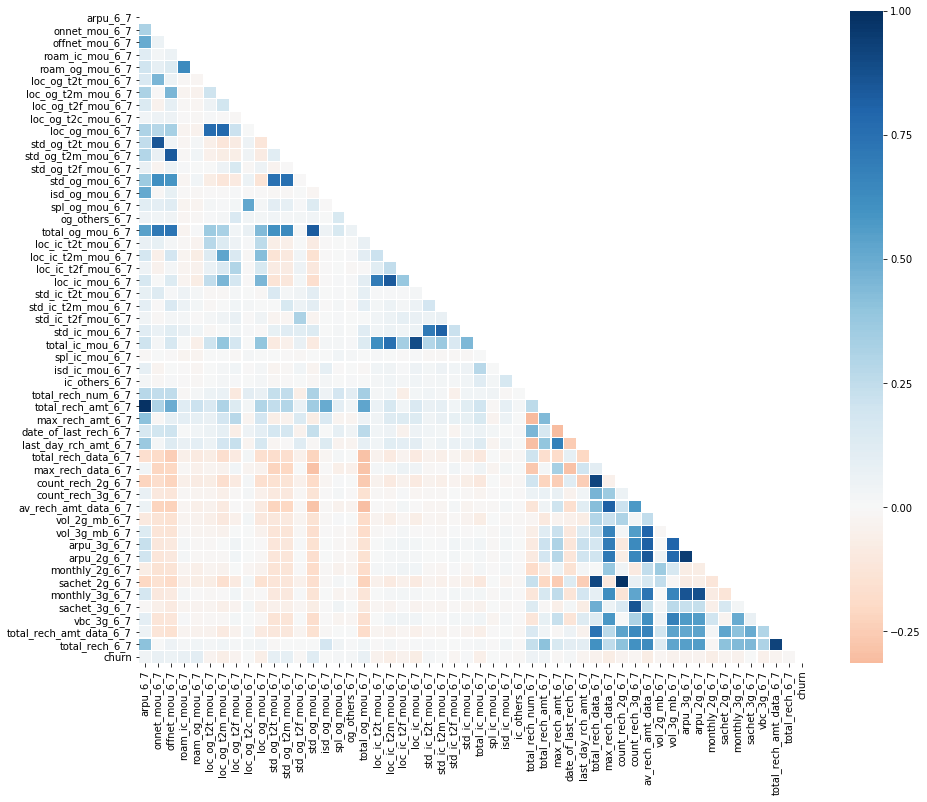

In [40]:
#Correlation of Good Phase Data
col = [c for c in hvCust.columns if c.endswith('_6_7') ] + ['churn']
corrData_6_7 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_6_7, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_6_7, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

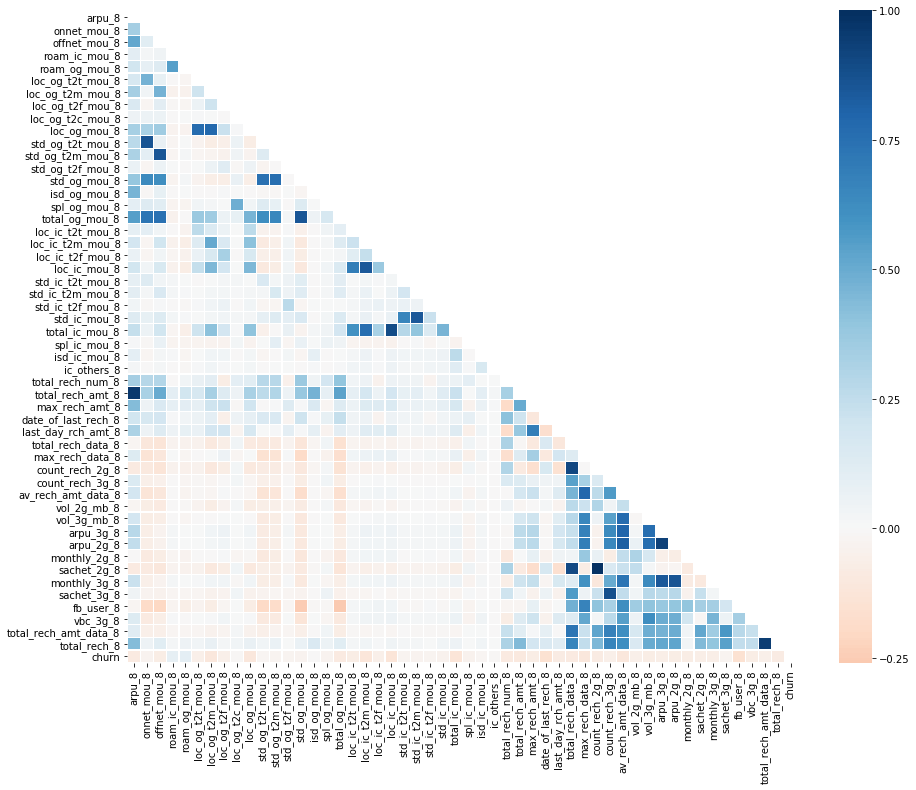

In [41]:
#Correlation of Action Phase Data
col = [c for c in hvCust.columns if c.endswith('_8') ] + ['churn']
corrData_8 = hvCust[col].corr()
plt.figure(figsize=(15,12))
mask = np.zeros_like(corrData_8, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrData_8, cmap='RdBu', mask=mask, center=0, linewidths= 0.1)
plt.show()

Both heatmap shows similar trend, will drop few highly correlated column.

In [42]:
for c in corrData_6_7.columns:
    corrCol = corrData_6_7[(corrData_6_7[c] >= 0.8) & (corrData_6_7[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_6_7.loc[c, corrCol[0]]))
print()        
print('-----------------------------------------------------------------')
print()
for c in corrData_8.columns:
    corrCol = corrData_8[(corrData_8[c] >= 0.8) & (corrData_8[c] < 1)].index
    if (corrCol.size > 0):
        print("'{0}' correlated with '{1}' : {2}".format(c, corrCol[0], corrData_8.loc[c, corrCol[0]]))

'arpu_6_7' correlated with 'total_rech_amt_6_7' : 0.9807394665291236
'onnet_mou_6_7' correlated with 'std_og_t2t_mou_6_7' : 0.8532342495252453
'offnet_mou_6_7' correlated with 'std_og_t2m_mou_6_7' : 0.8378648579136188
'std_og_t2t_mou_6_7' correlated with 'onnet_mou_6_7' : 0.8532342495252453
'std_og_t2m_mou_6_7' correlated with 'offnet_mou_6_7' : 0.8378648579136188
'std_og_mou_6_7' correlated with 'total_og_mou_6_7' : 0.8306598698014078
'total_og_mou_6_7' correlated with 'std_og_mou_6_7' : 0.8306598698014078
'loc_ic_t2m_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8390201505961243
'loc_ic_mou_6_7' correlated with 'loc_ic_t2m_mou_6_7' : 0.8390201505961243
'std_ic_t2m_mou_6_7' correlated with 'std_ic_mou_6_7' : 0.8148677594191372
'std_ic_mou_6_7' correlated with 'std_ic_t2m_mou_6_7' : 0.8148677594191372
'total_ic_mou_6_7' correlated with 'loc_ic_mou_6_7' : 0.8918093650110335
'total_rech_amt_6_7' correlated with 'arpu_6_7' : 0.9807394665291236
'total_rech_data_6_7' correlated with 'count_

In [43]:
#Let's drop highly correlated Columns
colToDrop = ['total_rech_amt_6_7','total_rech_amt_8','std_og_t2t_mou_6_7','std_og_t2t_mou_8','std_og_t2m_mou_6_7','std_og_t2m_mou_8','std_og_mou_6_7','std_og_mou_8','loc_ic_mou_6_7','loc_ic_mou_8','std_ic_t2m_mou_6_7','std_ic_t2m_mou_8','total_rech_data_6_7','total_rech_data_8','sachet_3g_6_7','sachet_3g_8','sachet_2g_6_7','sachet_2g_8']
hvCust.drop(labels=colToDrop, inplace=True, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [44]:
hvCust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28163 entries, 7 to 99997
Data columns (total 89 columns):
mobile_number              28163 non-null int64
arpu_8                     28163 non-null float64
onnet_mou_8                28163 non-null float64
offnet_mou_8               28163 non-null float64
roam_ic_mou_8              28163 non-null float64
roam_og_mou_8              28163 non-null float64
loc_og_t2t_mou_8           28163 non-null float64
loc_og_t2m_mou_8           28163 non-null float64
loc_og_t2f_mou_8           28163 non-null float64
loc_og_t2c_mou_8           28163 non-null float64
loc_og_mou_8               28163 non-null float64
std_og_t2f_mou_8           28163 non-null float64
isd_og_mou_8               28163 non-null float64
spl_og_mou_8               28163 non-null float64
total_og_mou_8             28163 non-null float64
loc_ic_t2t_mou_8           28163 non-null float64
loc_ic_t2m_mou_8           28163 non-null float64
loc_ic_t2f_mou_8           28163 non-null f

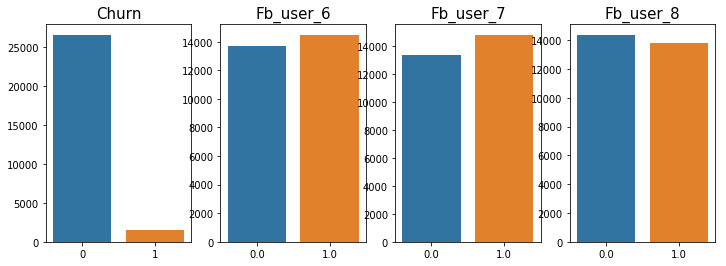

In [45]:
cols = ['fb_user_6','fb_user_7','fb_user_8','churn']
n_cols = 4
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(12,4))
for i,c in enumerate(sorted(cols)):
    plt.subplot(n_rows, n_cols, i+1)
    ax = sns.countplot(x=hvCust[c])
    ax.set_xlabel('')
    ax.set_ylabel('')

    plt.title(c.capitalize(), y=1, fontsize=15)
    
plt.show()

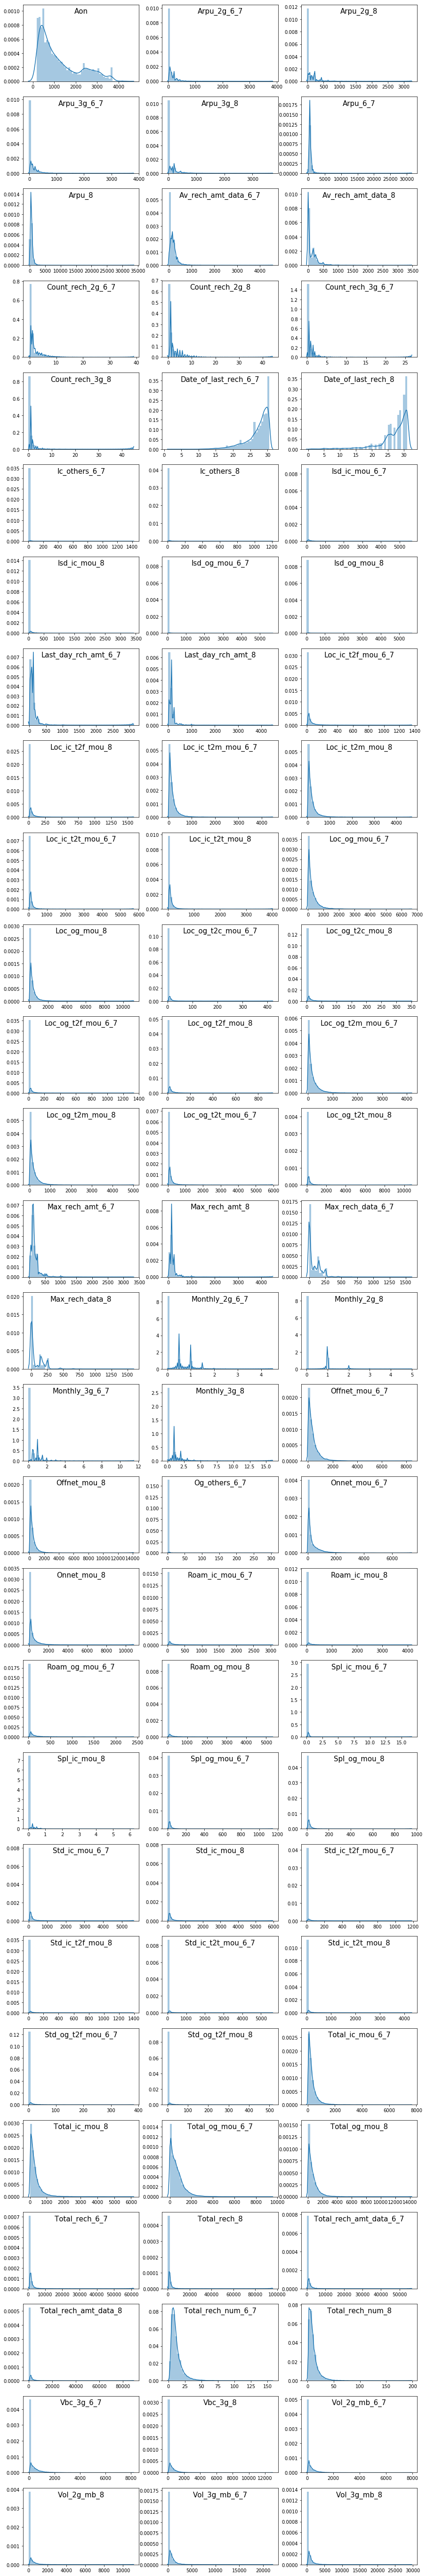

In [46]:
cols = hvCust.columns[~hvCust.columns.isin(['mobile_number','fb_user_6','fb_user_7','fb_user_8','churn'])]
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)
plt.figure(figsize=(15,100))
for i,c in enumerate(sorted(cols)):
    plt.subplot(n_rows, n_cols, i+1)
    ax = sns.distplot(hvCust[c])
    ax.set_xlabel('')
    
    plt.title(c.capitalize(), y=0.85, fontsize=15)
    
plt.show()

All feature variables are either skewed to right or left, not a single variable showing normal distribution.<BR>
We are analyzing high value customers which is nothing but outliers, so we can expect such trend in all other variable. Hence instead of removing outlier data will start building model.

## Model Building

In [47]:
#data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA

#Util
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold

#Model Algo
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Model Evluation
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [48]:
#Split Train & Test Data
Y = hvCust['churn']
X = hvCust.drop(labels=['churn','mobile_number'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.5, random_state = 100, stratify = Y)
print("Train Set :", X_train.shape, Y_train.shape)
print("Test Set :", X_test.shape, Y_test.shape)

Train Set : (14081, 87) (14081,)
Test Set : (14082, 87) (14082,)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [49]:
#Scale data using Standard Scaler
sc = StandardScaler()
X_train[X_train.columns] = sc.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = sc.transform(X_test[X_test.columns])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [50]:
#Instead of building model on all feature will fetch important feature using RFE
rfe = RFE(LogisticRegression(), n_features_to_select=60)
rfe.fit(X_train, Y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=60, step=1, verbose=0)

In [51]:
rfeDF = pd.DataFrame(data=np.array([X_train.columns, rfe.support_, rfe.ranking_]).T, columns=['Feature', 'Support', 'Ranking'])
rfeDF[rfeDF['Support']]

,Feature,Support,Ranking
0,arpu_8,True,1
1,onnet_mou_8,True,1
2,offnet_mou_8,True,1
4,roam_og_mou_8,True,1
5,loc_og_t2t_mou_8,True,1
7,loc_og_t2f_mou_8,True,1
8,loc_og_t2c_mou_8,True,1
9,loc_og_mou_8,True,1
12,spl_og_mou_8,True,1
13,total_og_mou_8,True,1


In [52]:
pca = PCA(svd_solver='randomized', random_state=100)
pca.fit(X_train[rfeDF[rfeDF['Support']]['Feature']])
#pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
  svd_solver='randomized', tol=0.0, whiten=False)

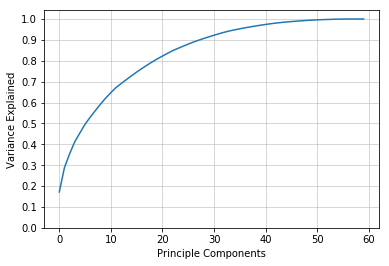

In [53]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(linestyle='-', linewidth = 0.5)
plt.xlabel('Principle Components')
plt.ylabel('Variance Explained')
plt.show()

In [54]:
np.cumsum(pca.explained_variance_ratio_)[np.arange(29,60,5)]

array([0.91464022, 0.94821164, 0.97020354, 0.98565913, 0.99476477,
       0.99930105, 1.        ])

In [55]:
np.cumsum(pca.explained_variance_ratio_)#[np.arange(30,60,5)]

array([0.17158912, 0.28844532, 0.354029  , 0.41214129, 0.45470996,
       0.49629817, 0.52994967, 0.56172889, 0.5925135 , 0.62146483,
       0.64754795, 0.67180758, 0.69096943, 0.70979629, 0.72810964,
       0.74598205, 0.76261967, 0.77901885, 0.79434763, 0.80899226,
       0.82256484, 0.83588245, 0.84863467, 0.85930044, 0.8697624 ,
       0.87991598, 0.88965519, 0.89830269, 0.90665225, 0.91464022,
       0.92238901, 0.92965571, 0.9366839 , 0.94286528, 0.94821164,
       0.95313167, 0.95782434, 0.96219439, 0.96632942, 0.97020354,
       0.97395571, 0.97741596, 0.98057192, 0.98324472, 0.98565913,
       0.98783776, 0.98972466, 0.99156167, 0.99333164, 0.99476477,
       0.99587437, 0.99696112, 0.99782757, 0.99865906, 0.99930105,
       0.99991463, 0.99996213, 0.99999586, 0.99999938, 1.        ])

**91%** variance explained by **30** PC<BR>
**94%** variance explained by **35** PC<BR>
**96%** variance explained by **40** PC<BR>
**98%** variance explained by **45** PC<BR>
**99%** variance explained by **50** PC<BR>
**100%** variance explained by **55** PC<BR>
So, we can choose **40 or 45** PC for model building which explained **96% - 98%** variance.

In [56]:
pca = IncrementalPCA(n_components=40)
pca_train = pca.fit_transform(X_train[rfeDF[rfeDF['Support']]['Feature']])
pca_test = pca.transform(X_test[rfeDF[rfeDF['Support']]['Feature']])

In [57]:
folds = StratifiedKFold(n_splits = 5, random_state = 100, shuffle = True)

In [58]:
lr = LogisticRegression()
param = {'C' : [1,10,100,1000]}
model_cv = GridSearchCV(lr, param_grid=param, scoring='recall', cv=folds, n_jobs=-1, verbose=1, return_train_score=True)
model_cv.fit(pca_train, Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='recall', verbose=1)

In [59]:
lrScore = pd.DataFrame(model_cv.cv_results_)
lrScore[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,1,0.126095,0.128410
1,10,0.127394,0.130361
2,100,0.127394,0.130686
3,1000,0.127394,0.130686


In [60]:
asdas

NameError: name 'asdas' is not defined

In [ ]:
Y_train.value_counts()

In [61]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)
param = {'C' : [0.001,0.1,1]}
svc = SVC(kernel='linear')
model_scv_li = GridSearchCV(svc,
                             param_grid=param, 
                             scoring='precision', 
                             cv=folds, 
                             verbose=1,
                             n_jobs = -1,
                             return_train_score=True)
model_scv_li.fit(pca_train, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.1, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='precision', verbose=1)

In [62]:
model_scv_li_Score = pd.DataFrame(model_scv_li.cv_results_)
model_scv_li_Score[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,0.001,0.0,0.0
1,0.1,0.0,0.0
2,1,0.0,0.0


In [ ]:
svc = SVC(kernel='linear')
param = {'C' : [0.01, 0.1, 1, 10]}
#param = {'C' : [0.1]}
model_svc_lr = GridSearchCV(svc, param_grid=param, cv=2, scoring='accuracy', n_jobs=-1, verbose=1, return_train_score=True)
model_svc_lr.fit(pca_train, Y_train)

In [ ]:
scvlrScore = pd.DataFrame(model_svc_lr.cv_results_)
scvlrScore[['param_C','mean_test_score','mean_train_score']]

param = {'C' : [0.01, 0.1, 1, 10]}
svc = SVC(kernel='linear')
model_scv_li = GridSearchCV(svc,
                             param_grid=param, 
                             scoring='accuracy', 
                             cv=folds, 
                             verbose=1,
                             n_jobs = -1,
                             return_train_score=True)
model_scv_li.fit(pca_train, Y_train)

In [81]:
svc = SVC(kernel='poly')
param = {'C' : [ 0.1, 1,10,100],
        'gamma': [0.01,0.1,10,100]}
model_svc_poly = GridSearchCV(svc, param_grid=param, cv=folds, scoring='recall', verbose=1, n_jobs=-1, return_train_score=True)
model_svc_poly.fit(pca_train, Y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 31.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [82]:
scvpolyScore = pd.DataFrame(model_svc_poly.cv_results_)
scvpolyScore[['param_C','mean_test_score','mean_train_score']]

,param_C,mean_test_score,mean_train_score
0,0.1,0.005195,0.023406
1,0.1,0.111833,0.314356
2,0.1,0.371848,1.000000
3,0.1,0.371848,1.000000
4,1,0.015594,0.055264
5,1,0.300374,0.666448
6,1,0.371848,1.000000
7,1,0.371848,1.000000
8,10,0.027291,0.116058
9,10,0.392702,0.886534


In [79]:
svc = SVC(kernel='rbf')
param = {'C' : [1,10,100],
        'gamma': [0.1,1,10]}
model_svc_rbf = GridSearchCV(svc, param_grid=param, cv=folds, scoring='recall', verbose=1, n_jobs=-1, return_train_score=True)
model_svc_rbf.fit(pca_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 18.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 10, 100], 'gamma': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [80]:
scvrbfScore = pd.DataFrame(model_svc_rbf.cv_results_)
scvrbfScore[['param_C', 'param_gamma','mean_test_score','mean_train_score']]

,param_C,param_gamma,mean_test_score,mean_train_score
0,1,0.1,0.109246,0.341345
1,1,1,0.031227,0.916772
2,1,10,0.000000,1.000000
3,10,0.1,0.284802,0.873858
4,10,1,0.049411,1.000000
5,10,10,0.000000,1.000000
6,100,0.1,0.274368,0.981469
7,100,1,0.049411,1.000000
8,100,10,0.000000,1.000000
